# 서울시 셀프주유소 유가 분석

- https://www.opinet.co.kr/searRgSelect.do
- 목표 데이터 : 브랜드, 가격, 셀프 주유 여부, 위치

---
## 1. selenium webdriver로 URL 접근

In [68]:
from selenium import webdriver

url = "https://www.opinet.co.kr/searRgSelect.do"
driver = webdriver.Chrome()

driver.get(url)

---
## 2. 지역 : 시/도, 시/군/구 추출

### 지역의 시, 도 탭 찾기
- find_element()
- 시 선택 태그의 아이디 : SIDO_NM0
- 구 선택 태그의 아이디 : SIGUNGU_NM0

In [69]:
from selenium.webdriver.common.by import By

sido_list_raw = driver.find_element(By.ID, "SIDO_NM0")

print(sido_list_raw.text)

            시/도
            
             
             
              서울
             
            
             
             
              부산
             
            
             
             
              대구
             
            
             
             
              인천
             
            
             
             
              광주
             
            
             
             
              대전
             
            
             
             
              울산
             
            
             
             
              세종
             
            
             
              경기
             
             
            
             
             
              강원
             
            
             
             
              충북
             
            
             
             
              충남
             
            
             
             
              전북
             
            
             
             
       

### 시/도 값 추출
- 시 태그 하위에는 전국 시가 담겨있는 option태그들이 있다.
- 여러 개의 option 태그들이므로 값을 찾을 때는 find_elements() 사용
- 태그 선택 방식은 By 클래스의 TAG_NAME 사용

In [70]:
sido_list = sido_list_raw.find_elements(By.TAG_NAME, "option")

for sido in sido_list :
    print(sido.text)

시/도
서울
부산
대구
인천
광주
대전
울산
세종
경기
강원
충북
충남
전북
전남
경북
경남
제주


- option 태그의 value값과 option태그의 text 값이 서로 다르다. (예 : value="서울특별시"이지만 text는 "서울")
- value값을 가져오기 위해서는 get_attribute("value")를 사용한다.

In [71]:
print(sido_list[1].get_attribute("value"))

# sido_names 리스트에 담기
sido_names = [option.get_attribute("value") for option in sido_list]

# sido_list의 첫번째 값은 "시/도"이므로 sido_names에서 제외시켜주기
sido_names = sido_names[1:]

sido_names

서울특별시


['서울특별시',
 '부산광역시',
 '대구광역시',
 '인천광역시',
 '광주광역시',
 '대전광역시',
 '울산광역시',
 '세종특별자치시',
 '경기도',
 '강원특별자치도',
 '충청북도',
 '충청남도',
 '전북특별자치도',
 '전라남도',
 '경상북도',
 '경상남도',
 '제주특별자치도']

### 추출한 시/도 값을 입력시켜보기
- send_keys()

In [72]:
# 서울특별시
sido_list_raw.send_keys(sido_names[0])

### 같은 방법으로 시/군/구 태그도 처리

In [73]:
# 시/군/구 값 추출
gu_list_raw = driver.find_element(By.ID, "SIGUNGU_NM0") 
gu_list = gu_list_raw.find_elements(By.TAG_NAME, "option")

gu_names = [option.get_attribute("value") for option in gu_list]
gu_names = gu_names[1:]

gu_names

['강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구']

In [74]:
# 추출한 시/군/구 값 입력해보기
gu_list_raw.send_keys(gu_names[0])

---
## 3. 엑셀 저장 버튼 클릭
- CSS_SELECTOR를 통해 태그 찾기
- 태그를 찾아 click() 이벤트 실행

In [75]:
driver.find_element(By.CSS_SELECTOR, "#templ_list0 > div:nth-child(7) > div > a").click()

- 정상적으로 저장되는 것이 확인되었으면, 반복문을 통해 서울시 모든 구의 유가 검색 결과를 엑셀로 저장해보자

In [77]:
import time
from tqdm import tqdm

for gu in tqdm(gu_names) :
    # 시/군/구 태그 선택
    element = driver.find_element(By.ID, "SIGUNGU_NM0")

    # 시/군/구 태그에 각 구 이름 입력시키기
    element.send_keys(gu)
    time.sleep(5)

    # 엑셀 저장
    driver.find_element(By.CSS_SELECTOR, "#templ_list0 > div:nth-child(7) > div > a").click()
    time.sleep(5)

100%|██████████| 25/25 [04:24<00:00, 10.58s/it]


---
## 4. 수집한 데이터 정리
- 다운로드한 25개의 엑셀 파일들을 확인하고 하나의 파일로 정리하기

### 파일 목록 한 번에 가져오기
- glob 모듈 활용

In [84]:
import pandas as pd
import shutil
import os
from glob import glob


oil_excel_files = glob('/Users/taeheon/Downloads/지역_*.xls')
len(oil_excel_files)

25

- 25개의 엑셀 파일을 현재 작업 환경의 data/data04 폴더로 옮겨주자

In [85]:
# data폴더 아래에 data04 폴더 생성
os.makedirs('../data/data04')

In [86]:
# data/data04폴더로 oil_excel_files 파일들 이동
for file in oil_excel_files :
    shutil.move(file, '../data/data04')

### 각 엑셀 파일 정리하기

In [90]:
# 새로운 디렉토리에 저장된 엑셀 파일 변수에 담기
station_files = glob('../data/data04/지역_*.xls')
tmp = pd.read_excel(station_files[0])

tmp.head()

,지역_위치별(주유소),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(단위 : 원/리터)
1,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
2,서울특별시,(주)헨지스에너지 구도일주유소 도봉,서울 도봉구 도봉로 706 (방학동),S-OIL,02-3491-3454,Y,-,1515,1335,-
3,서울특별시,삼미북부셀프주유소,서울 도봉구 도봉로 437 (쌍문동),SK에너지,02-992-5561,Y,-,1515,1335,-
4,서울특별시,(주)자연에너지 햇살주유소,서울 도봉구 방학로 142 (방학동),HD현대오일뱅크,02-954-4555,Y,1780,1515,1335,-


- header=2 부터 불러와보자

In [92]:
tmp = pd.read_excel(station_files[0], header=2)

tmp.head()

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
0,서울특별시,(주)헨지스에너지 구도일주유소 도봉,서울 도봉구 도봉로 706 (방학동),S-OIL,02-3491-3454,Y,-,1515,1335,-
1,서울특별시,삼미북부셀프주유소,서울 도봉구 도봉로 437 (쌍문동),SK에너지,02-992-5561,Y,-,1515,1335,-
2,서울특별시,(주)자연에너지 햇살주유소,서울 도봉구 방학로 142 (방학동),HD현대오일뱅크,02-954-4555,Y,1780,1515,1335,-
3,서울특별시,한이에너지(주) 쌍문주유소,서울 도봉구 도봉로 547 (쌍문동),S-OIL,02-992-0220,Y,1780,1515,1335,-
4,서울특별시,도봉제일주유소(주)송만에너지,서울 도봉구 도봉로 783 (도봉동),HD현대오일뱅크,02-955-5185,N,-,1515,1335,1290


### 모든 엑셀 파일 하나로 합치기
- pd.concat()

In [94]:
# 각 엑셀파일을 읽어온 결과를 저장할 빈 리스트
tmp_raw = []

for file_name in station_files :
    tmp = pd.read_excel(file_name, header=2)
    tmp_raw.append(tmp)

tmp_raw

[       지역                   상호                    주소        상표          전화번호  \
 0   서울특별시  (주)헨지스에너지 구도일주유소 도봉  서울 도봉구 도봉로 706 (방학동)     S-OIL  02-3491-3454   
 1   서울특별시            삼미북부셀프주유소  서울 도봉구 도봉로 437 (쌍문동)     SK에너지   02-992-5561   
 2   서울특별시       (주)자연에너지 햇살주유소  서울 도봉구 방학로 142 (방학동)  HD현대오일뱅크   02-954-4555   
 3   서울특별시       한이에너지(주) 쌍문주유소  서울 도봉구 도봉로 547 (쌍문동)     S-OIL   02-992-0220   
 4   서울특별시      도봉제일주유소(주)송만에너지  서울 도봉구 도봉로 783 (도봉동)  HD현대오일뱅크   02-955-5185   
 5   서울특별시          이케이에너지 주식회사  서울 도봉구 도봉로 941 (도봉동)  HD현대오일뱅크  02-3494-3641   
 6   서울특별시       지에스칼텍스㈜ 방학동주유소        서울 도봉구 방학로 186     GS칼텍스  02-3493-5189   
 7   서울특별시         대성산업(주)신창주유소   서울 도봉구 덕릉로 267 (창동)     GS칼텍스   02-905-4441   
 8   서울특별시        동일석유(주) 창동주유소  서울 도봉구  도봉로 434 (창동)     SK에너지   02-902-5544   
 9   서울특별시           구도일주유소 파크빌  서울 도봉구 해등로3길 86 (창동)     S-OIL   02-906-5104   
 10  서울특별시        극동유화(주) 대안주유소   서울 도봉구 마들로 574 (창동)     S-OIL   02-996-6640   
 11  서울특별시           (주)쌍문셀프

In [95]:
# tmp_raw 리스트 안에 들어간 데이터프레임들을 하나의 데이터프레임으로 합치기
stations_raw = pd.concat(tmp_raw)
stations_raw

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
0,서울특별시,(주)헨지스에너지 구도일주유소 도봉,서울 도봉구 도봉로 706 (방학동),S-OIL,02-3491-3454,Y,-,1515,1335,-
1,서울특별시,삼미북부셀프주유소,서울 도봉구 도봉로 437 (쌍문동),SK에너지,02-992-5561,Y,-,1515,1335,-
2,서울특별시,(주)자연에너지 햇살주유소,서울 도봉구 방학로 142 (방학동),HD현대오일뱅크,02-954-4555,Y,1780,1515,1335,-
3,서울특별시,한이에너지(주) 쌍문주유소,서울 도봉구 도봉로 547 (쌍문동),S-OIL,02-992-0220,Y,1780,1515,1335,-
4,서울특별시,도봉제일주유소(주)송만에너지,서울 도봉구 도봉로 783 (도봉동),HD현대오일뱅크,02-955-5185,N,-,1515,1335,1290
...,...,...,...,...,...,...,...,...,...,...
3,서울특별시,HD현대오일뱅크㈜직영 사당셀프주유소,서울 동작구 동작대로 73 (사당동),HD현대오일뱅크,02-521-3618,Y,1909,1595,1465,-
4,서울특별시,HD현대오일뱅크㈜직영 흑석동셀프주유소,서울 동작구 현충로 101 (흑석동),HD현대오일뱅크,02-815-0724,Y,1848,1608,1474,-
5,서울특별시,HD현대오일뱅크㈜직영 동작주유소,서울 동작구 상도로 403 (상도동),HD현대오일뱅크,02-817-9179,N,1859,1613,1479,-
6,서울특별시,매일주유소,서울 동작구 상도로 139 (상도동),S-OIL,02-817-4085,Y,-,1679,1559,1650


### 합쳐진 데이터 프레임 정리
- columns = ["상호", "주소", "가격", "셀프여부", "상표"]

In [98]:
stations_raw.columns

Index(['지역', '상호', '주소', '상표', '전화번호', '셀프여부', '고급휘발유', '휘발유', '경유', '실내등유'], dtype='object')

In [99]:
# 정리된 새로운 데이터프레임 생성
stations = pd.DataFrame({
    "상호" : stations_raw['상호'],
    "주소" : stations_raw['주소'],
    "가격" : stations_raw['휘발유'],
    "셀프" : stations_raw['셀프여부'],
    "상표" : stations_raw['상표']
})

stations.head()

,상호,주소,가격,셀프,상표
0,(주)헨지스에너지 구도일주유소 도봉,서울 도봉구 도봉로 706 (방학동),1515,Y,S-OIL
1,삼미북부셀프주유소,서울 도봉구 도봉로 437 (쌍문동),1515,Y,SK에너지
2,(주)자연에너지 햇살주유소,서울 도봉구 방학로 142 (방학동),1515,Y,HD현대오일뱅크
3,한이에너지(주) 쌍문주유소,서울 도봉구 도봉로 547 (쌍문동),1515,Y,S-OIL
4,도봉제일주유소(주)송만에너지,서울 도봉구 도봉로 783 (도봉동),1515,N,HD현대오일뱅크


- 주소를 기준으로 속해있는 구 추출하여 데이터프레임에 새로운 컬럼으로 붙여주자.

In [115]:
# 주소 하나만 가지고 먼저 테스트
tmp = list(stations['주소'])[0].split()

print(tmp)
print(tmp[1])   # 구

['서울', '도봉구', '도봉로', '706', '(방학동)']
도봉구


In [103]:
# 반복문으로 구 이름만 추출
for each_address in stations['주소'] :
    print(each_address.split()[1])

도봉구
도봉구
도봉구
도봉구
도봉구
도봉구
도봉구
도봉구
도봉구
도봉구
도봉구
도봉구
도봉구
도봉구
도봉구
마포구
마포구
마포구
마포구
마포구
마포구
마포구
마포구
마포구
마포구
마포구
마포구
광진구
광진구
광진구
광진구
광진구
광진구
광진구
광진구
광진구
광진구
광진구
광진구
중랑구
중랑구
중랑구
중랑구
중랑구
중랑구
중랑구
중랑구
중랑구
중랑구
중랑구
중랑구
관악구
관악구
관악구
관악구
관악구
관악구
관악구
관악구
관악구
관악구
관악구
관악구
관악구
관악구
서대문구
서대문구
서대문구
서대문구
서대문구
서대문구
서대문구
서대문구
서대문구
서대문구
서대문구
서대문구
서대문구
서대문구
노원구
노원구
노원구
노원구
노원구
노원구
노원구
노원구
노원구
노원구
노원구
노원구
노원구
노원구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
강서구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
양천구
종로구
종로구
종로구
종로구
종로구
종로구
종로구
종로구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
서초구
성동구
성동구
성동구
성동구
성동구
성동구
성동구
성동구
성동구
성동구
성동구
성동구
성동구
성동구
성동구
성동구
중구
중구
중구
중구
중구
중구
중구
중구
중구
중구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
영등포구
강

In [118]:
# "구" 컬럼 생성
stations['구'] = [each_address.split()[1] for each_address in stations['주소']]

stations.head()

,상호,주소,가격,셀프,상표,구
0,(주)헨지스에너지 구도일주유소 도봉,서울 도봉구 도봉로 706 (방학동),1515,Y,S-OIL,도봉구
1,삼미북부셀프주유소,서울 도봉구 도봉로 437 (쌍문동),1515,Y,SK에너지,도봉구
2,(주)자연에너지 햇살주유소,서울 도봉구 방학로 142 (방학동),1515,Y,HD현대오일뱅크,도봉구
3,한이에너지(주) 쌍문주유소,서울 도봉구 도봉로 547 (쌍문동),1515,Y,S-OIL,도봉구
4,도봉제일주유소(주)송만에너지,서울 도봉구 도봉로 783 (도봉동),1515,N,HD현대오일뱅크,도봉구


In [120]:
# 구 이름이 25개인지 unique를 통해 확인
stations['구'].unique(), len(stations['구'].unique())

(array(['도봉구', '마포구', '광진구', '중랑구', '관악구', '서대문구', '노원구', '강서구', '양천구',
        '종로구', '서초구', '성동구', '중구', '영등포구', '강북구', '용산구', '강동구', '성북구',
        '송파구', '은평구', '동대문구', '강남구', '금천구', '구로구', '동작구'], dtype=object),
 25)

- 가격 데이터를 float으로 형변환 시켜주자

In [130]:
stations['가격'] = stations['가격'].astype(float)

ValueError: could not convert string to float: '-'

- '-' 문자는 float으로 형변환할 수 없다는 에러 메세지가 떴다.
- '-' 값이 담겨있는 데이터를 확인해보자

In [132]:
stations[stations['가격'] == '-']

,상호,주소,가격,셀프,상표,구
13,CJ대한통운㈜ 신림주유소,서울 관악구 남부순환로 1515 (신림동),-,N,GS칼텍스,관악구
13,HD현대오일뱅크㈜직영 독립문주유소,서울 서대문구 통일로 384 (홍제동),-,N,HD현대오일뱅크,서대문구
29,HD현대오일뱅크㈜직영 도곡셀프주유소,서울 강남구 남부순환로 2718,-,Y,HD현대오일뱅크,강남구


- 가격이 명시되어 있지 않은 주유소는 데이터프레임에서 제외시켜주자

In [133]:
stations = stations[stations['가격'] != '-']

stations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 423 entries, 0 to 7
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   상호      423 non-null    object
 1   주소      423 non-null    object
 2   가격      423 non-null    object
 3   셀프      423 non-null    object
 4   상표      423 non-null    object
 5   구       423 non-null    object
dtypes: object(6)
memory usage: 23.1+ KB


In [142]:
# 다시 가격 데이터 형변환해주자
stations['가격'] = stations['가격'].astype(float)

- 정리된 데이터프레임의 Index는 423이지만 값이 0 ~ 7인걸 알 수 있다.
- 이는 합쳐진 데이터프레임이 423개의 행을 가지고 있지만, 합쳐지는 과정에서 각 데이터프레임의 인덱스 값을 그대로 가져와 생긴 문제
- reset_index()를 통해 인덱스를 정리해주자

In [143]:
stations.reset_index(inplace=True)

stations.head()

,index,상호,주소,가격,셀프,상표,구
0,0,(주)헨지스에너지 구도일주유소 도봉,서울 도봉구 도봉로 706 (방학동),1515.0,Y,S-OIL,도봉구
1,1,삼미북부셀프주유소,서울 도봉구 도봉로 437 (쌍문동),1515.0,Y,SK에너지,도봉구
2,2,(주)자연에너지 햇살주유소,서울 도봉구 방학로 142 (방학동),1515.0,Y,HD현대오일뱅크,도봉구
3,3,한이에너지(주) 쌍문주유소,서울 도봉구 도봉로 547 (쌍문동),1515.0,Y,S-OIL,도봉구
4,4,도봉제일주유소(주)송만에너지,서울 도봉구 도봉로 783 (도봉동),1515.0,N,HD현대오일뱅크,도봉구


In [144]:
stations.tail()

,index,상호,주소,가격,셀프,상표,구
418,418,HD현대오일뱅크㈜직영 사당셀프주유소,서울 동작구 동작대로 73 (사당동),1595.0,Y,HD현대오일뱅크,동작구
419,419,HD현대오일뱅크㈜직영 흑석동셀프주유소,서울 동작구 현충로 101 (흑석동),1608.0,Y,HD현대오일뱅크,동작구
420,420,HD현대오일뱅크㈜직영 동작주유소,서울 동작구 상도로 403 (상도동),1613.0,N,HD현대오일뱅크,동작구
421,421,매일주유소,서울 동작구 상도로 139 (상도동),1679.0,Y,S-OIL,동작구
422,422,살피재주유소,서울 동작구 상도로 334,1785.0,N,SK에너지,동작구


In [145]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   423 non-null    int64  
 1   상호      423 non-null    object 
 2   주소      423 non-null    object 
 3   가격      423 non-null    float64
 4   셀프      423 non-null    object 
 5   상표      423 non-null    object 
 6   구       423 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 23.3+ KB


- 새로 생성된 index 컬럼을 삭제해주자

In [146]:
del stations['index']

stations.head()

,상호,주소,가격,셀프,상표,구
0,(주)헨지스에너지 구도일주유소 도봉,서울 도봉구 도봉로 706 (방학동),1515.0,Y,S-OIL,도봉구
1,삼미북부셀프주유소,서울 도봉구 도봉로 437 (쌍문동),1515.0,Y,SK에너지,도봉구
2,(주)자연에너지 햇살주유소,서울 도봉구 방학로 142 (방학동),1515.0,Y,HD현대오일뱅크,도봉구
3,한이에너지(주) 쌍문주유소,서울 도봉구 도봉로 547 (쌍문동),1515.0,Y,S-OIL,도봉구
4,도봉제일주유소(주)송만에너지,서울 도봉구 도봉로 783 (도봉동),1515.0,N,HD현대오일뱅크,도봉구


---
## 5. 주유 가격 정보 시각화 

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import font_manager, rc

get_ipython().run_line_magic("matplotlib", "inline")
%matplotlib inline


rc("font", family="Arial Unicode MS")

### boxplot 시각화

- pandas의 boxplot

<Axes: title={'center': '가격'}, xlabel='셀프'>

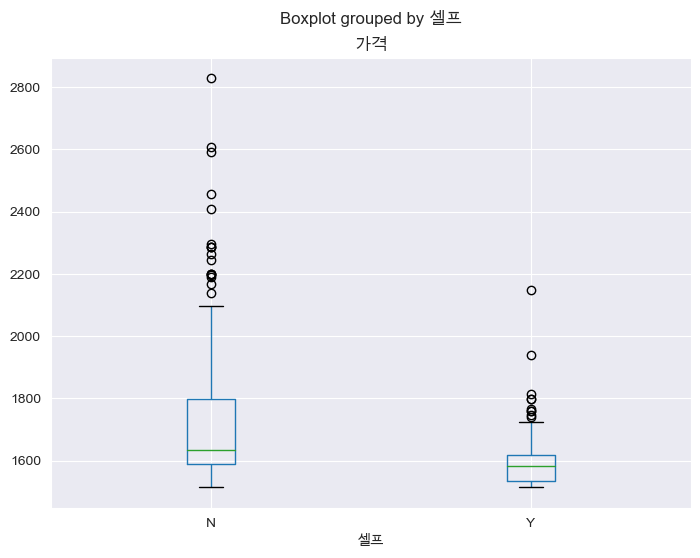

In [166]:
stations.boxplot(by="셀프", column="가격", figsize=(8, 6))

- seaborn의 boxplot

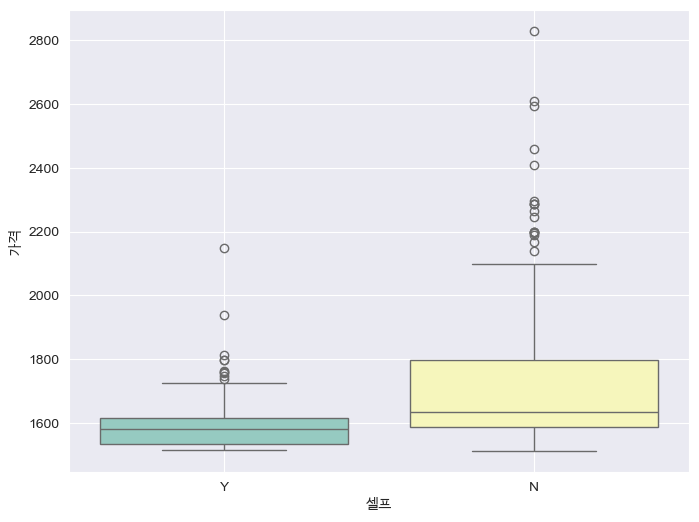

In [169]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="셀프", y="가격", data=stations, palette="Set3", hue="셀프")
plt.grid(True)
plt.show()

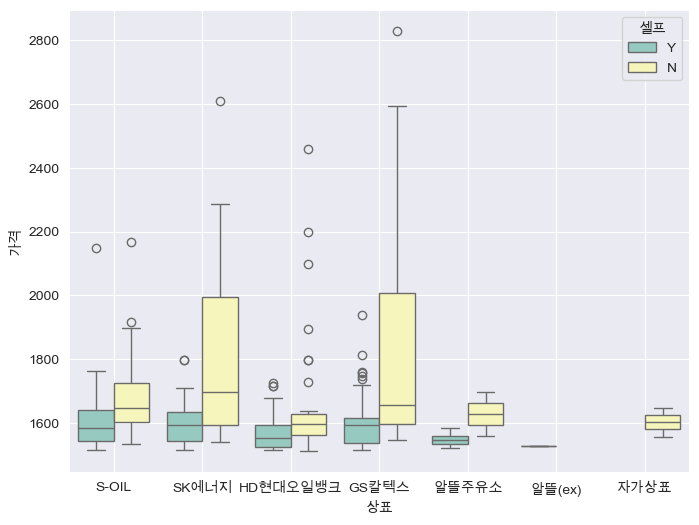

In [170]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="상표", y="가격", data=stations, palette="Set3", hue="셀프")
plt.grid(True)
plt.show()

### 지도 시각화

In [183]:
import json
import folium
import numpy as np

- 가장 비싼 주유소 10개 확인

In [182]:
stations.sort_values(by="가격", ascending=False).head(10)

,상호,주소,가격,셀프,상표,구
261,서계주유소,서울 용산구 청파로 367 (청파동),2829.0,N,GS칼텍스,용산구
212,서남주유소,서울 중구 통일로 30,2608.0,N,SK에너지,중구
385,(주)만정에너지 삼보주유소,서울 강남구 봉은사로 433 (삼성동),2593.0,N,GS칼텍스,강남구
384,(주)제이제이네트웍스 제이제이주유소,서울 강남구 언주로 716,2458.0,N,HD현대오일뱅크,강남구
211,필동주유소,서울 중구 퇴계로 196 (필동2가),2409.0,N,GS칼텍스,중구
239,SJ오일(주) 여의도주유소,서울 영등포구 은행로 64,2295.0,N,GS칼텍스,영등포구
260,에너비스,서울 용산구 한남대로 82 (한남동),2287.0,N,SK에너지,용산구
259,한남지점,서울 용산구 한남대로21길 4 (한남동),2287.0,N,SK에너지,용산구
383,SK논현주유소,서울 강남구 논현로 747 (논현동),2285.0,N,SK에너지,강남구
155,(주)대양씨앤씨 사직주유소,서울 종로구 사직로 65 (사직동),2265.0,N,GS칼텍스,종로구


- 가장 저렴한 주유소 10개 확인

In [184]:
stations.sort_values(by="가격", ascending=True).head(10)

,상호,주소,가격,셀프,상표,구
326,(주)디오티디 은평유니콘주유소,서울 은평구 통일로 1151 (진관동),1514.0,N,HD현대오일뱅크,은평구
0,(주)헨지스에너지 구도일주유소 도봉,서울 도봉구 도봉로 706 (방학동),1515.0,Y,S-OIL,도봉구
277,이케이에너지㈜ 강산주유소,서울 성북구 보문로 27 (보문동7가),1515.0,Y,GS칼텍스,성북구
276,이케이에너지(주) 강산제2주유소,서울 성북구 보국문로 52,1515.0,Y,HD현대오일뱅크,성북구
275,(주)삼표에너지 정릉주유소,서울 성북구 보국문로 35 (정릉동),1515.0,Y,GS칼텍스,성북구
246,수유동주유소,서울 강북구 도봉로 395 (수유동),1515.0,Y,GS칼텍스,강북구
245,SK에너지(주) 매일주유소,서울 강북구 삼양로 217 (미아동),1515.0,Y,SK에너지,강북구
244,북서울고속주유소,서울 강북구 삼양로 410 (수유동),1515.0,Y,SK에너지,강북구
243,(주)서울에너지 시민주유소,서울 강북구 인수봉로 185 (수유동),1515.0,Y,HD현대오일뱅크,강북구
242,덕릉로주유소,서울 강북구 덕릉로 158 (번동),1515.0,Y,S-OIL,강북구


- "구"를 인덱스로 하도록 데이터프레임 pivot

In [186]:
gu_data = pd.pivot_table(data=stations, index='구', values='가격', aggfunc=np.mean)

gu_data.head()

,가격
구,
강남구,1853.482759
강동구,1704.000000
강북구,1527.400000
강서구,1613.030303
관악구,1631.230769


- folium 지도 시각화

In [195]:
geo_path = "../data/data02/02. skorea_municipalities_geo_simple.json"
geo_str = json.load(open(geo_path, encoding='utf-8'))

oil_map = folium.Map(location=[37.5502, 126.982], 
                     zoom_start=10.5,
                     tiles="Cartodb Positron")

# 경계선 표시
folium.Choropleth(
    geo_data=geo_str,
    data=gu_data,
    columns=[gu_data.index, "가격"],
    key_on="feature.id",
    fill_color="PuRd"
).add_to(oil_map)

oil_map